# Notebook B: Impermanent Loss & DeFi Yield Analysis

## Learning Objectives
- Understand impermanent loss mechanics and calculation
- Compare DeFi lending vs liquidity provision yields
- Analyze real-world LP performance with historical data
- Visualize IL across different price scenarios
- Calculate break-even points for LP strategies

---

## 1. Setup and Imports

In [1]:
# Import essential libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple
import warnings
import time
from scipy import optimize
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')

# Configure visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
%matplotlib inline

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("[SUCCESS] All libraries imported successfully")
print(f"Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

[SUCCESS] All libraries imported successfully
Session started: 2025-11-02 13:07:22


## 2. Impermanent Loss Theory & Formula

In [2]:
def calculate_impermanent_loss(price_ratio: float) -> float:
    """
    Calculate impermanent loss based on price ratio.
    
    Formula: IL = 2 * sqrt(price_ratio) / (1 + price_ratio) - 1
    
    Args:
        price_ratio: Final price / Initial price
    
    Returns:
        Impermanent loss as decimal (negative value)
    """
    if price_ratio <= 0:
        return -1.0  # Total loss
    
    il = 2 * np.sqrt(price_ratio) / (1 + price_ratio) - 1
    return il

def calculate_lp_position_value(initial_price: float, final_price: float, 
                                initial_investment: float = 10000) -> Dict:
    """
    Calculate LP position value and compare to HODL strategy.
    
    Assumes 50/50 pool (e.g., ETH/USDC).
    """
    # Initial position: 50% ETH, 50% USDC
    initial_eth = (initial_investment / 2) / initial_price
    initial_usdc = initial_investment / 2
    
    # Constant product: x * y = k
    k = initial_eth * initial_usdc
    
    # After price change, pool rebalances
    # New amounts: eth_new * usdc_new = k, and usdc_new / eth_new = final_price
    eth_new = np.sqrt(k / final_price)
    usdc_new = np.sqrt(k * final_price)
    
    # LP position value
    lp_value = eth_new * final_price + usdc_new
    
    # HODL value (just holding initial amounts)
    hodl_value = initial_eth * final_price + initial_usdc
    
    # Impermanent loss
    il_dollar = lp_value - hodl_value
    il_percent = (il_dollar / hodl_value) * 100
    
    price_ratio = final_price / initial_price
    
    return {
        'initial_price': initial_price,
        'final_price': final_price,
        'price_ratio': price_ratio,
        'price_change_%': (price_ratio - 1) * 100,
        'initial_eth': initial_eth,
        'initial_usdc': initial_usdc,
        'final_eth': eth_new,
        'final_usdc': usdc_new,
        'lp_value': lp_value,
        'hodl_value': hodl_value,
        'il_dollar': il_dollar,
        'il_percent': il_percent
    }

# Example calculation
print("\n[EXAMPLE] Impermanent Loss Calculation\n")
print("Scenario: ETH/USDC Pool, $10,000 initial investment\n")

scenarios = [
    (2000, 4000, "ETH 2x"),
    (2000, 1000, "ETH 0.5x"),
    (2000, 10000, "ETH 5x"),
    (2000, 400, "ETH 0.2x")
]

for initial, final, label in scenarios:
    result = calculate_lp_position_value(initial, final, 10000)
    print(f"{label}: ${initial} → ${final}")
    print(f"  LP Value: ${result['lp_value']:.2f}")
    print(f"  HODL Value: ${result['hodl_value']:.2f}")
    print(f"  IL: ${result['il_dollar']:.2f} ({result['il_percent']:.2f}%)\n")

print("="*80)


[EXAMPLE] Impermanent Loss Calculation

Scenario: ETH/USDC Pool, $10,000 initial investment

ETH 2x: $2000 → $4000
  LP Value: $14142.14
  HODL Value: $15000.00
  IL: $-857.86 (-5.72%)

ETH 0.5x: $2000 → $1000
  LP Value: $7071.07
  HODL Value: $7500.00
  IL: $-428.93 (-5.72%)

ETH 5x: $2000 → $10000
  LP Value: $22360.68
  HODL Value: $30000.00
  IL: $-7639.32 (-25.46%)

ETH 0.2x: $2000 → $400
  LP Value: $4472.14
  HODL Value: $6000.00
  IL: $-1527.86 (-25.46%)



## 3. VISUALIZATION 1: Impermanent Loss Curves (4 Charts)

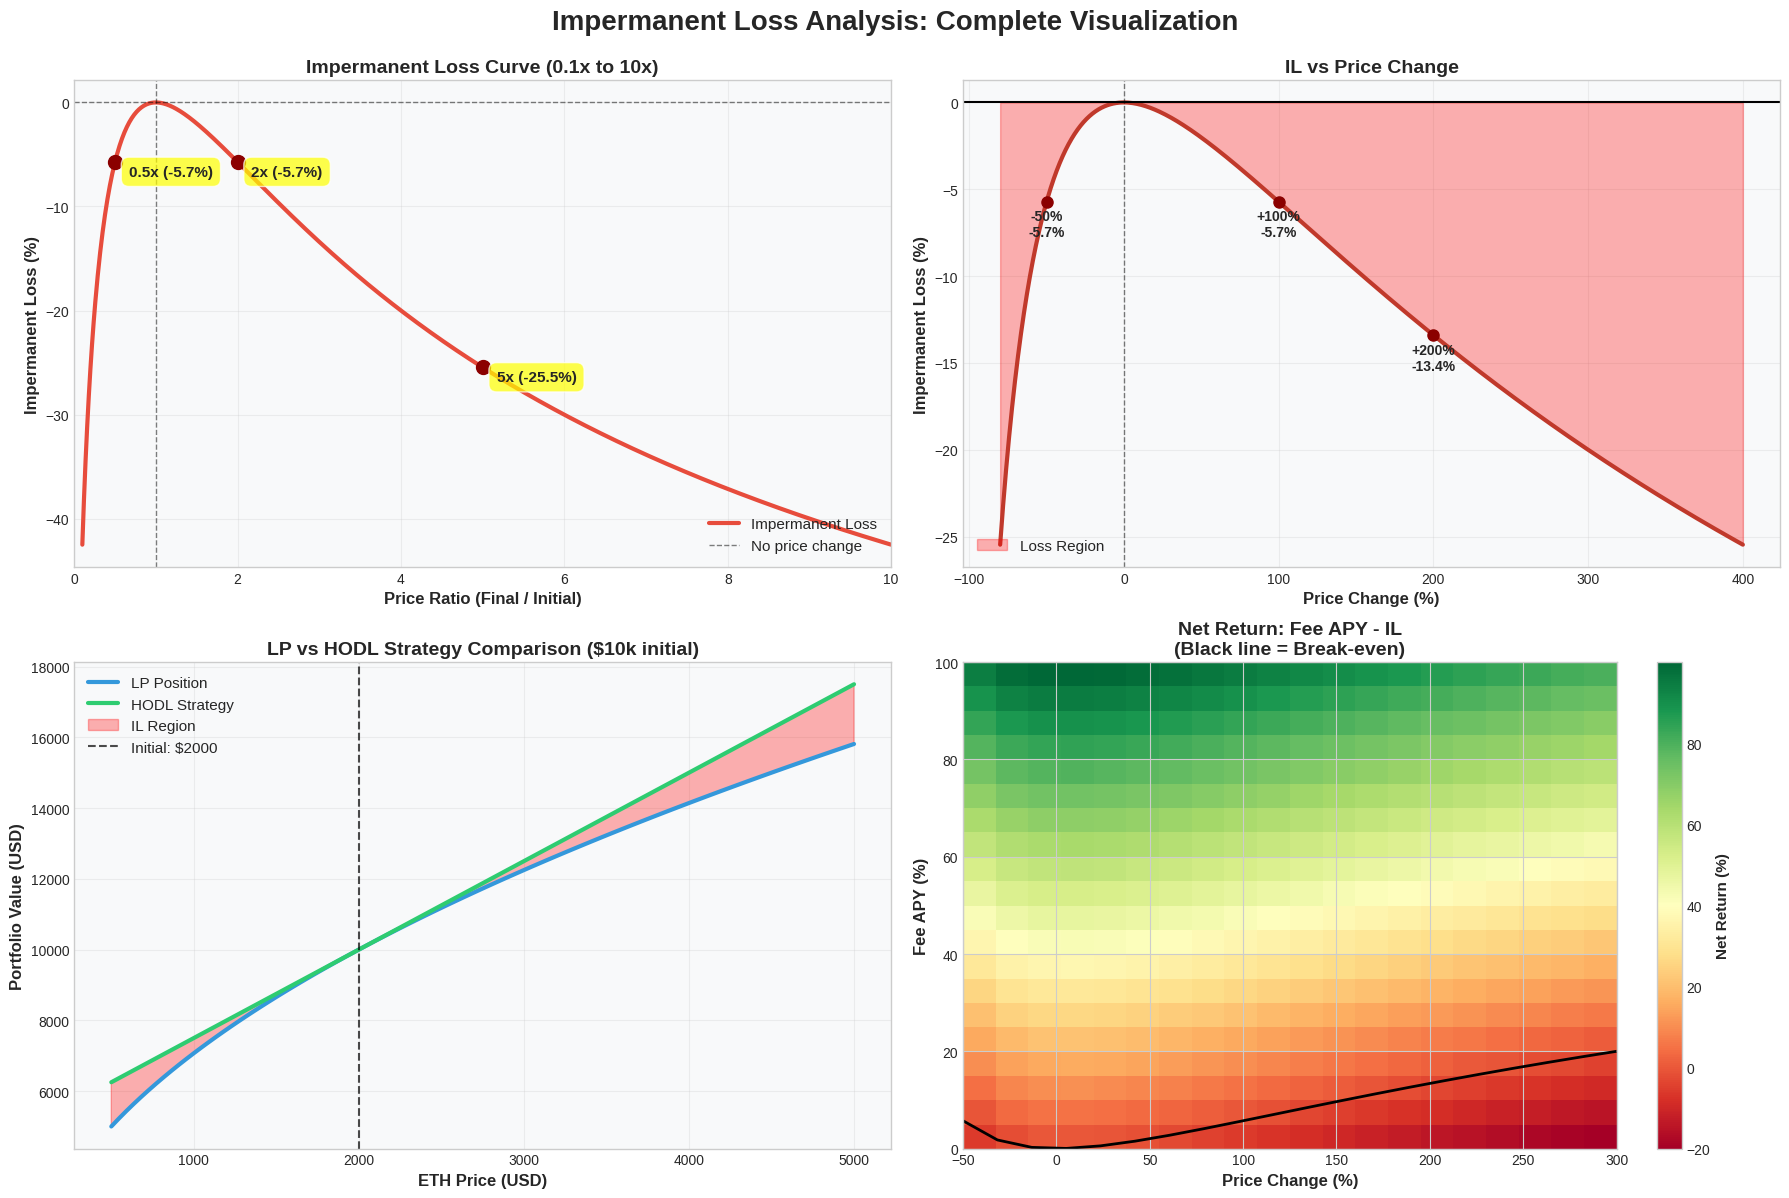


[VISUALIZATION 1] Impermanent Loss curves complete!


In [3]:
# Generate IL data across price ranges
price_ratios = np.linspace(0.1, 10, 1000)
il_values = [calculate_impermanent_loss(pr) * 100 for pr in price_ratios]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Impermanent Loss Analysis: Complete Visualization', 
             fontsize=20, fontweight='bold', y=0.995)

# Plot 1: IL Curve (Full Range)
ax1 = axes[0, 0]
ax1.plot(price_ratios, il_values, linewidth=3, color='#e74c3c', label='Impermanent Loss')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(x=1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='No price change')

# Highlight key points
key_points = [(0.5, calculate_impermanent_loss(0.5)*100, '0.5x (-5.7%)'),
              (2.0, calculate_impermanent_loss(2.0)*100, '2x (-5.7%)'),
              (5.0, calculate_impermanent_loss(5.0)*100, '5x (-25.5%)')]

for pr, il, label in key_points:
    ax1.plot(pr, il, 'o', markersize=10, color='darkred')
    ax1.annotate(label, (pr, il), xytext=(10, -10), textcoords='offset points',
                fontsize=11, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax1.set_xlabel('Price Ratio (Final / Initial)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Impermanent Loss (%)', fontsize=12, fontweight='bold')
ax1.set_title('Impermanent Loss Curve (0.1x to 10x)', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 10)

# Plot 2: IL vs Price Change (±100%)
ax2 = axes[0, 1]
price_changes = np.linspace(-80, 400, 500)
il_vs_change = [calculate_impermanent_loss(1 + pc/100) * 100 for pc in price_changes]

ax2.fill_between(price_changes, il_vs_change, 0, alpha=0.3, color='red', label='Loss Region')
ax2.plot(price_changes, il_vs_change, linewidth=3, color='#c0392b')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Add reference lines
for pc, label in [(100, '+100%'), (-50, '-50%'), (200, '+200%')]:
    il_val = calculate_impermanent_loss(1 + pc/100) * 100
    ax2.plot([pc], [il_val], 'o', markersize=8, color='darkred')
    ax2.text(pc, il_val - 2, f'{label}\n{il_val:.1f}%', ha='center', 
            fontsize=10, fontweight='bold')

ax2.set_xlabel('Price Change (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Impermanent Loss (%)', fontsize=12, fontweight='bold')
ax2.set_title('IL vs Price Change', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left', fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: LP Value vs HODL Value Comparison
ax3 = axes[1, 0]
price_range = np.linspace(500, 5000, 100)
initial_price = 2000
initial_investment = 10000

lp_values = []
hodl_values = []

for final_price in price_range:
    result = calculate_lp_position_value(initial_price, final_price, initial_investment)
    lp_values.append(result['lp_value'])
    hodl_values.append(result['hodl_value'])

ax3.plot(price_range, lp_values, linewidth=3, label='LP Position', color='#3498db')
ax3.plot(price_range, hodl_values, linewidth=3, label='HODL Strategy', color='#2ecc71')
ax3.fill_between(price_range, lp_values, hodl_values, 
                 where=np.array(hodl_values) > np.array(lp_values),
                 alpha=0.3, color='red', label='IL Region')
ax3.axvline(x=initial_price, color='black', linestyle='--', linewidth=1.5, 
           alpha=0.7, label=f'Initial: ${initial_price}')

ax3.set_xlabel('ETH Price (USD)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Portfolio Value (USD)', fontsize=12, fontweight='bold')
ax3.set_title('LP vs HODL Strategy Comparison ($10k initial)', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: IL Heatmap (Price Change vs Time Held)
ax4 = axes[1, 1]
# Simulate: At what APY do fees offset IL?
price_changes_heat = np.linspace(-50, 300, 20)
apys = np.linspace(0, 100, 20)

heatmap_data = np.zeros((len(apys), len(price_changes_heat)))

for i, apy in enumerate(apys):
    for j, pc in enumerate(price_changes_heat):
        il = calculate_impermanent_loss(1 + pc/100) * 100
        # Net return = Fee APY - IL (annualized assumption)
        net_return = apy + il  # IL is negative
        heatmap_data[i, j] = net_return

im = ax4.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', origin='lower',
               extent=[price_changes_heat[0], price_changes_heat[-1], apys[0], apys[-1]])

ax4.contour(price_changes_heat, apys, heatmap_data, levels=[0], colors='black', linewidths=2)
ax4.set_xlabel('Price Change (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Fee APY (%)', fontsize=12, fontweight='bold')
ax4.set_title('Net Return: Fee APY - IL\n(Black line = Break-even)', 
             fontsize=14, fontweight='bold')
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Net Return (%)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n[VISUALIZATION 1] Impermanent Loss curves complete!")

## 4. Fetch Historical Price Data for Real-World IL Simulation

In [4]:
# API Configuration
COINGECKO_API = 'https://api.coingecko.com/api/v3'

def fetch_api(url: str, params: Dict = None, max_retries: int = 3) -> Dict:
    """Fetch data with exponential backoff."""
    for attempt in range(max_retries):
        try:
            time.sleep(1.5 * (attempt + 1))
            response = requests.get(url, params=params, timeout=30)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"[ERROR] API Error: {e}")
                return None
    return None

def get_historical_prices(coin_id: str, days: int = 90) -> pd.DataFrame:
    """Fetch historical price data."""
    url = f"{COINGECKO_API}/coins/{coin_id}/market_chart"
    params = {'vs_currency': 'usd', 'days': days, 'interval': 'daily'}
    
    data = fetch_api(url, params)
    
    if data and 'prices' in data:
        df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df[['date', 'price']]
    
    return pd.DataFrame()

# Fetch ETH price data for simulation
print("\n[DATA] Fetching historical ETH prices for real-world IL simulation...\n")

df_eth = get_historical_prices('ethereum', days=90)

if not df_eth.empty:
    print(f"[SUCCESS] Fetched {len(df_eth)} days of ETH price data")
    print(f"Date range: {df_eth['date'].min().date()} to {df_eth['date'].max().date()}")
    print(f"Price range: ${df_eth['price'].min():.2f} to ${df_eth['price'].max():.2f}")
else:
    print("[ERROR] Failed to fetch ETH data. Using simulated data...")
    # Generate simulated data as fallback
    dates = pd.date_range(end=datetime.now(), periods=90, freq='D')
    prices = 2000 + np.cumsum(np.random.randn(90) * 50)
    df_eth = pd.DataFrame({'date': dates, 'price': prices})

print("\n" + "="*80)


[DATA] Fetching historical ETH prices for real-world IL simulation...

[SUCCESS] Fetched 91 days of ETH price data
Date range: 2025-08-05 to 2025-11-02
Price range: $3612.44 to $4829.23



## 5. Real-World IL Simulation: ETH/USDC Pool

In [5]:
def simulate_lp_performance(price_history: pd.DataFrame, 
                           initial_investment: float = 10000,
                           fee_apy: float = 20.0) -> pd.DataFrame:
    """
    Simulate LP performance over time with fee accumulation.
    
    Args:
        price_history: DataFrame with 'date' and 'price' columns
        initial_investment: Starting capital
        fee_apy: Annual percentage yield from trading fees
    
    Returns:
        DataFrame with daily LP and HODL values
    """
    results = []
    initial_price = price_history.iloc[0]['price']
    
    for idx, row in price_history.iterrows():
        days_elapsed = (row['date'] - price_history.iloc[0]['date']).days
        current_price = row['price']
        
        # Calculate LP position
        lp_calc = calculate_lp_position_value(initial_price, current_price, initial_investment)
        
        # Add accumulated fees (daily compounding)
        daily_fee_rate = (1 + fee_apy/100) ** (1/365) - 1
        fees_accumulated = initial_investment * ((1 + daily_fee_rate) ** days_elapsed - 1)
        
        lp_value_with_fees = lp_calc['lp_value'] + fees_accumulated
        hodl_value = lp_calc['hodl_value']
        
        # Net profit/loss
        lp_profit = lp_value_with_fees - initial_investment
        hodl_profit = hodl_value - initial_investment
        
        results.append({
            'date': row['date'],
            'price': current_price,
            'days_elapsed': days_elapsed,
            'lp_value_no_fees': lp_calc['lp_value'],
            'fees_accumulated': fees_accumulated,
            'lp_value_with_fees': lp_value_with_fees,
            'hodl_value': hodl_value,
            'il_dollar': lp_calc['il_dollar'],
            'il_percent': lp_calc['il_percent'],
            'lp_profit': lp_profit,
            'hodl_profit': hodl_profit,
            'lp_profit_%': (lp_profit / initial_investment) * 100,
            'hodl_profit_%': (hodl_profit / initial_investment) * 100
        })
    
    return pd.DataFrame(results)

# Simulate with different fee APYs
print("\n[SIMULATION] Real-world LP performance (ETH/USDC pool, $10k initial)\n")

fee_scenarios = [10, 20, 30, 50]
simulations = {}

for fee_apy in fee_scenarios:
    sim = simulate_lp_performance(df_eth, initial_investment=10000, fee_apy=fee_apy)
    simulations[fee_apy] = sim
    
    final_lp = sim.iloc[-1]['lp_value_with_fees']
    final_hodl = sim.iloc[-1]['hodl_value']
    final_il = sim.iloc[-1]['il_percent']
    
    print(f"Fee APY: {fee_apy}%")
    print(f"  Final LP Value: ${final_lp:.2f} (+{sim.iloc[-1]['lp_profit_%']:.2f}%)")
    print(f"  Final HODL Value: ${final_hodl:.2f} (+{sim.iloc[-1]['hodl_profit_%']:.2f}%)")
    print(f"  IL: {final_il:.2f}%")
    print(f"  LP vs HODL: ${final_lp - final_hodl:+.2f}\n")

print("="*80)


[SIMULATION] Real-world LP performance (ETH/USDC pool, $10k initial)

Fee APY: 10%
  Final LP Value: $10412.39 (+4.12%)
  Final HODL Value: $10178.84 (+1.79%)
  IL: -0.02%
  LP vs HODL: $+233.55

Fee APY: 20%
  Final LP Value: $10631.87 (+6.32%)
  Final HODL Value: $10178.84 (+1.79%)
  IL: -0.02%
  LP vs HODL: $+453.02

Fee APY: 30%
  Final LP Value: $10837.91 (+8.38%)
  Final HODL Value: $10178.84 (+1.79%)
  IL: -0.02%
  LP vs HODL: $+659.07

Fee APY: 50%
  Final LP Value: $11216.46 (+12.16%)
  Final HODL Value: $10178.84 (+1.79%)
  IL: -0.02%
  LP vs HODL: $+1037.62



## 6. VISUALIZATION 2: Real-World LP Performance (4 Charts)

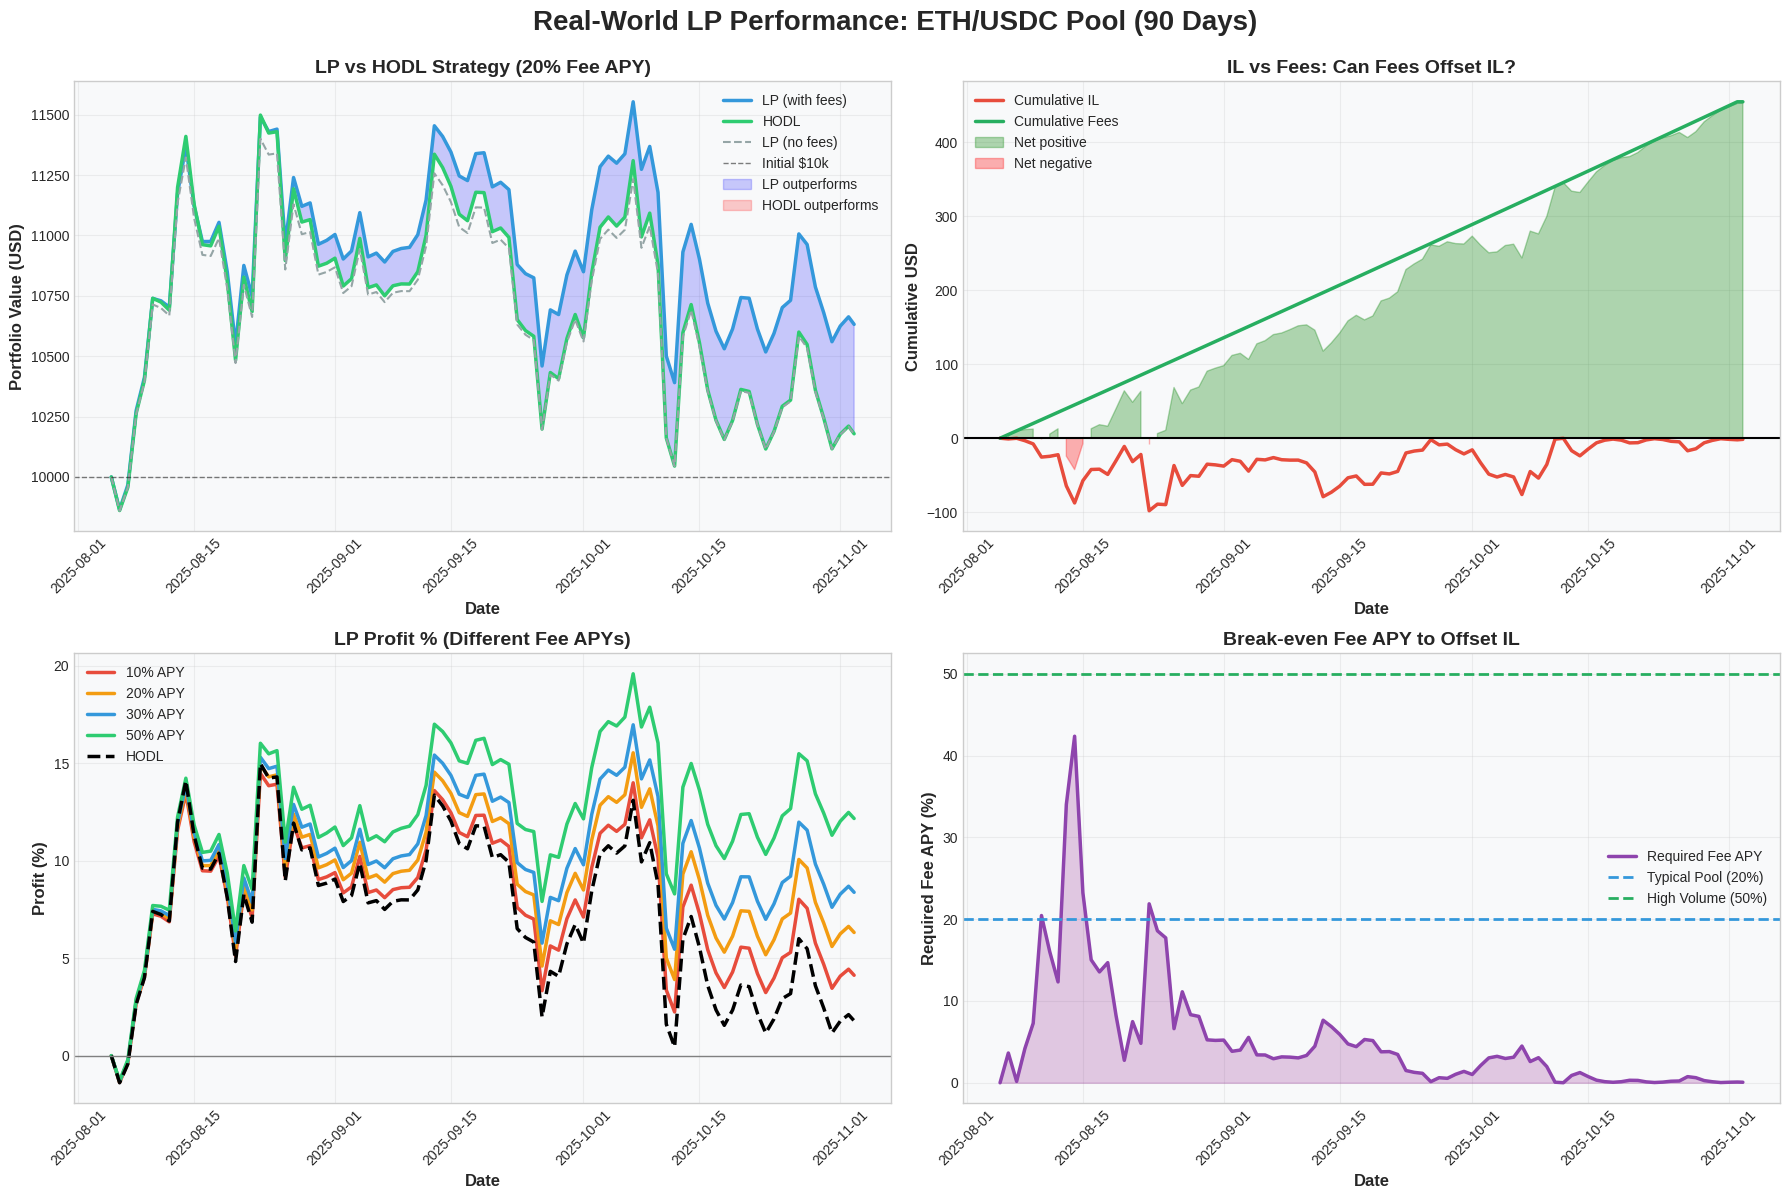


[VISUALIZATION 2] Real-world LP simulation complete!


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Real-World LP Performance: ETH/USDC Pool (90 Days)', 
             fontsize=20, fontweight='bold', y=0.995)

# Plot 1: LP Value vs HODL (20% Fee APY)
ax1 = axes[0, 0]
sim_20 = simulations[20]

ax1.plot(sim_20['date'], sim_20['lp_value_with_fees'], linewidth=2.5, 
        label='LP (with fees)', color='#3498db')
ax1.plot(sim_20['date'], sim_20['hodl_value'], linewidth=2.5, 
        label='HODL', color='#2ecc71')
ax1.plot(sim_20['date'], sim_20['lp_value_no_fees'], linewidth=1.5, 
        label='LP (no fees)', color='#95a5a6', linestyle='--')
ax1.axhline(y=10000, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Initial $10k')

ax1.fill_between(sim_20['date'], sim_20['lp_value_with_fees'], sim_20['hodl_value'],
                where=sim_20['lp_value_with_fees'] > sim_20['hodl_value'],
                alpha=0.2, color='blue', label='LP outperforms')
ax1.fill_between(sim_20['date'], sim_20['lp_value_with_fees'], sim_20['hodl_value'],
                where=sim_20['lp_value_with_fees'] <= sim_20['hodl_value'],
                alpha=0.2, color='red', label='HODL outperforms')

ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Portfolio Value (USD)', fontsize=12, fontweight='bold')
ax1.set_title('LP vs HODL Strategy (20% Fee APY)', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Cumulative IL vs Cumulative Fees
ax2 = axes[0, 1]
ax2.plot(sim_20['date'], sim_20['il_dollar'], linewidth=2.5, 
        label='Cumulative IL', color='#e74c3c')
ax2.plot(sim_20['date'], sim_20['fees_accumulated'], linewidth=2.5, 
        label='Cumulative Fees', color='#27ae60')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)

# Net effect
net_effect = sim_20['fees_accumulated'] + sim_20['il_dollar']
ax2.fill_between(sim_20['date'], 0, net_effect, alpha=0.3, 
                where=net_effect > 0, color='green', label='Net positive')
ax2.fill_between(sim_20['date'], 0, net_effect, alpha=0.3, 
                where=net_effect <= 0, color='red', label='Net negative')

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative USD', fontsize=12, fontweight='bold')
ax2.set_title('IL vs Fees: Can Fees Offset IL?', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Multiple Fee APY Scenarios
ax3 = axes[1, 0]
colors_fee = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']

for idx, fee_apy in enumerate(fee_scenarios):
    sim = simulations[fee_apy]
    ax3.plot(sim['date'], sim['lp_profit_%'], linewidth=2.5, 
            label=f'{fee_apy}% APY', color=colors_fee[idx])

# Add HODL for comparison
ax3.plot(sim_20['date'], sim_20['hodl_profit_%'], linewidth=2.5, 
        label='HODL', color='black', linestyle='--')
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=1)

ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.set_ylabel('Profit (%)', fontsize=12, fontweight='bold')
ax3.set_title('LP Profit % (Different Fee APYs)', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Break-even Analysis
ax4 = axes[1, 1]
# Calculate required fee APY to break even at each point
required_fees = []
for idx, row in sim_20.iterrows():
    if row['days_elapsed'] > 0:
        # Solve for APY where fees_accumulated + IL = 0
        il_abs = abs(row['il_dollar'])
        # fees = initial * ((1 + r)^days - 1), solve for r
        required_total_return = il_abs / 10000
        required_daily_rate = (1 + required_total_return) ** (1/row['days_elapsed']) - 1
        required_apy = ((1 + required_daily_rate) ** 365 - 1) * 100
        required_fees.append(min(required_apy, 200))  # Cap at 200%
    else:
        required_fees.append(0)

ax4.plot(sim_20['date'], required_fees, linewidth=2.5, color='#8e44ad', label='Required Fee APY')
ax4.axhline(y=20, color='#3498db', linestyle='--', linewidth=2, label='Typical Pool (20%)')
ax4.axhline(y=50, color='#27ae60', linestyle='--', linewidth=2, label='High Volume (50%)')
ax4.fill_between(sim_20['date'], 0, required_fees, alpha=0.2, color='purple')

ax4.set_xlabel('Date', fontsize=12, fontweight='bold')
ax4.set_ylabel('Required Fee APY (%)', fontsize=12, fontweight='bold')
ax4.set_title('Break-even Fee APY to Offset IL', fontsize=14, fontweight='bold')
ax4.legend(loc='best', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n[VISUALIZATION 2] Real-world LP simulation complete!")

## 7. DeFi Yield Comparison: Lending vs LP

In [7]:
# DeFi Protocol Yields (estimated/typical values)
defi_yields = {
    'Lending Protocols': [
        {'protocol': 'Aave USDC', 'apy': 5.2, 'risk': 'Low', 'type': 'Lending'},
        {'protocol': 'Compound USDC', 'apy': 4.8, 'risk': 'Low', 'type': 'Lending'},
        {'protocol': 'Aave ETH', 'apy': 2.1, 'risk': 'Low', 'type': 'Lending'},
        {'protocol': 'Spark DAI', 'apy': 6.5, 'risk': 'Low', 'type': 'Lending'},
    ],
    'Stablecoin LPs': [
        {'protocol': 'Curve 3pool', 'apy': 8.5, 'risk': 'Low', 'type': 'LP-Stable'},
        {'protocol': 'Curve FRAX/USDC', 'apy': 12.3, 'risk': 'Low', 'type': 'LP-Stable'},
        {'protocol': 'Balancer USDC/DAI', 'apy': 7.2, 'risk': 'Low', 'type': 'LP-Stable'},
    ],
    'Volatile LPs': [
        {'protocol': 'Uniswap V3 ETH/USDC', 'apy': 22.5, 'risk': 'Medium', 'type': 'LP-Volatile'},
        {'protocol': 'Uniswap V2 ETH/USDC', 'apy': 15.8, 'risk': 'Medium', 'type': 'LP-Volatile'},
        {'protocol': 'Sushiswap ETH/USDC', 'apy': 18.2, 'risk': 'Medium', 'type': 'LP-Volatile'},
        {'protocol': 'Balancer ETH/WBTC', 'apy': 25.7, 'risk': 'High', 'type': 'LP-Volatile'},
    ]
}

# Flatten data
all_yields = []
for category, items in defi_yields.items():
    all_yields.extend(items)

df_yields = pd.DataFrame(all_yields)

# Calculate risk-adjusted returns (simple: APY / risk_score)
risk_scores = {'Low': 1.0, 'Medium': 1.5, 'High': 2.5}
df_yields['risk_score'] = df_yields['risk'].map(risk_scores)
df_yields['risk_adjusted_apy'] = df_yields['apy'] / df_yields['risk_score']

print("\n[DATA] DeFi Yield Comparison\n")
print(df_yields.sort_values('apy', ascending=False).to_string(index=False))
print("\n" + "="*80)


[DATA] DeFi Yield Comparison

           protocol     apy   risk        type  risk_score  risk_adjusted_apy
  Balancer ETH/WBTC 25.7000   High LP-Volatile      2.5000            10.2800
Uniswap V3 ETH/USDC 22.5000 Medium LP-Volatile      1.5000            15.0000
 Sushiswap ETH/USDC 18.2000 Medium LP-Volatile      1.5000            12.1333
Uniswap V2 ETH/USDC 15.8000 Medium LP-Volatile      1.5000            10.5333
    Curve FRAX/USDC 12.3000    Low   LP-Stable      1.0000            12.3000
        Curve 3pool  8.5000    Low   LP-Stable      1.0000             8.5000
  Balancer USDC/DAI  7.2000    Low   LP-Stable      1.0000             7.2000
          Spark DAI  6.5000    Low     Lending      1.0000             6.5000
          Aave USDC  5.2000    Low     Lending      1.0000             5.2000
      Compound USDC  4.8000    Low     Lending      1.0000             4.8000
           Aave ETH  2.1000    Low     Lending      1.0000             2.1000



## 8. VISUALIZATION 3: DeFi Yield Landscape (4 Charts)

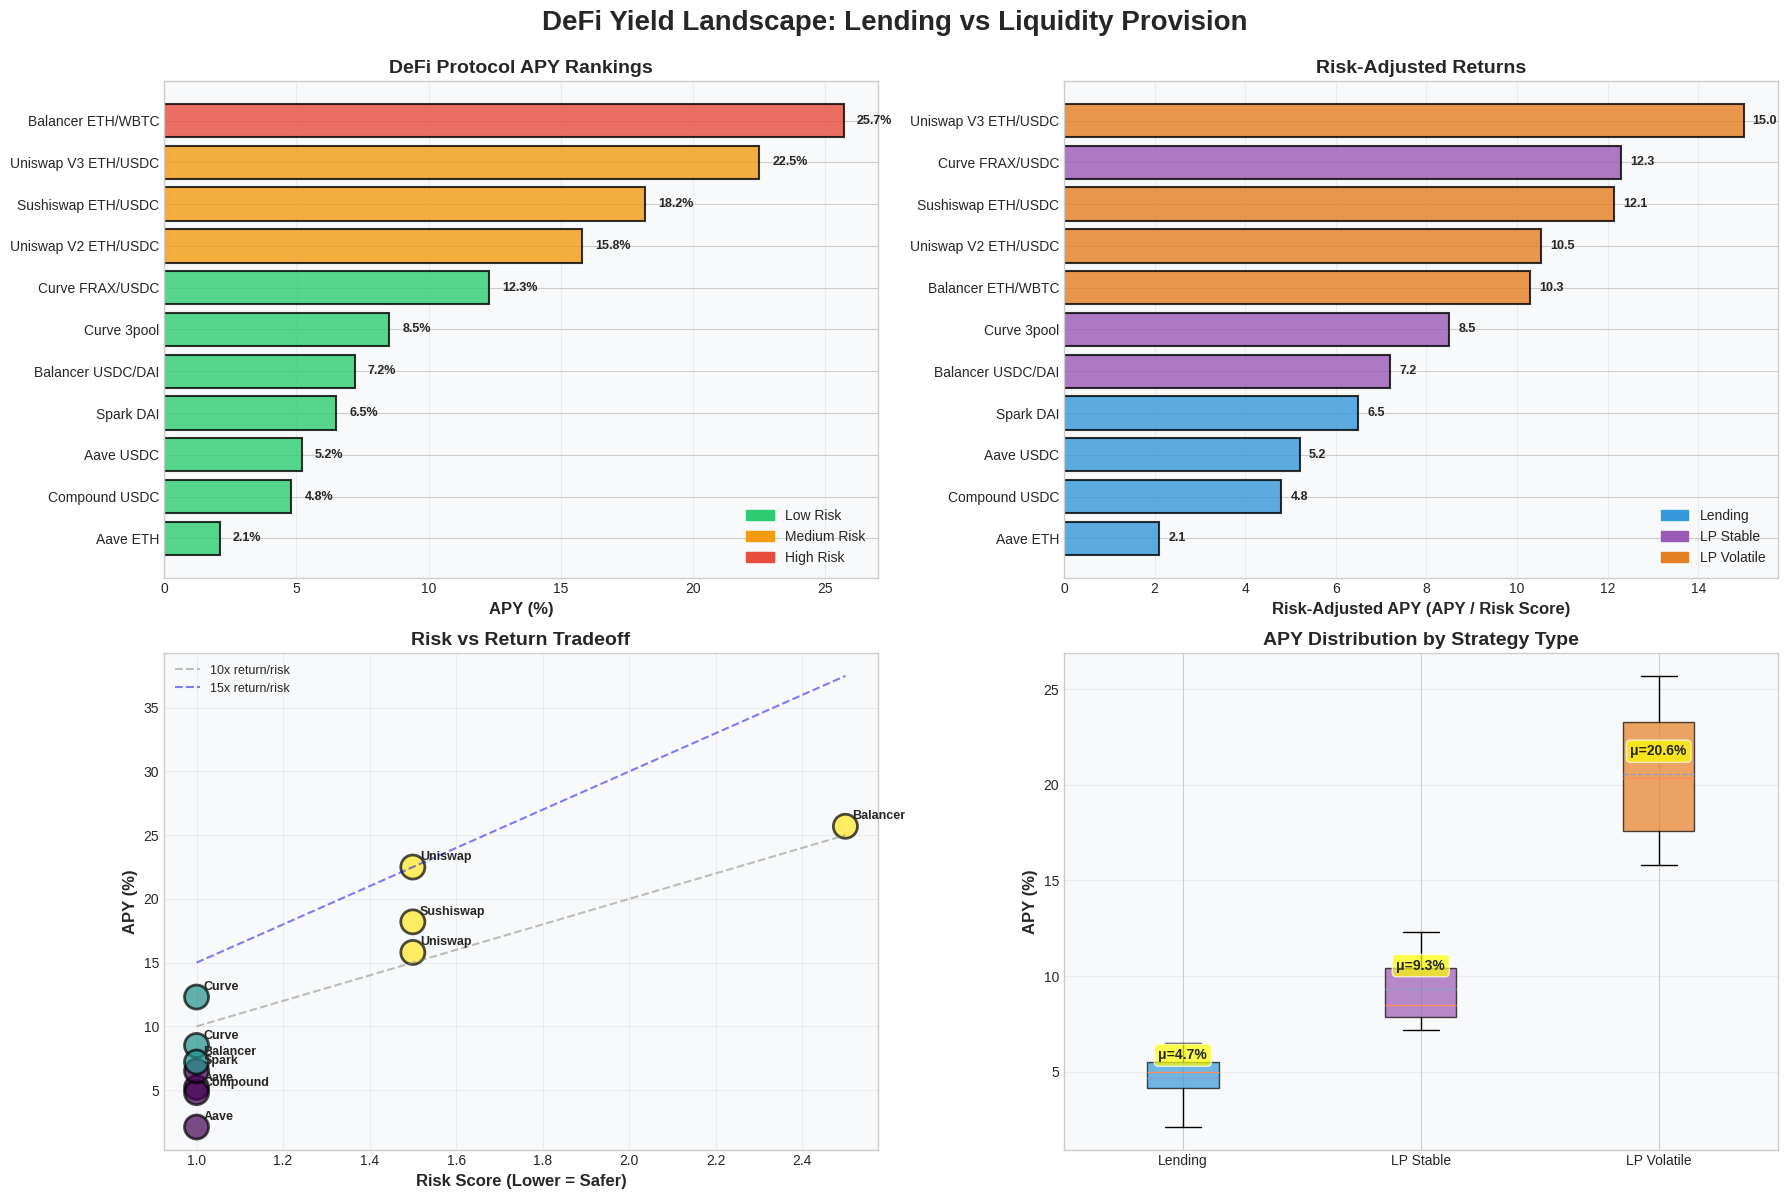


[VISUALIZATION 3] DeFi yield comparison complete!


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('DeFi Yield Landscape: Lending vs Liquidity Provision', 
             fontsize=20, fontweight='bold', y=0.995)

# Plot 1: APY Comparison (Bar Chart)
ax1 = axes[0, 0]
df_yields_sorted = df_yields.sort_values('apy', ascending=True)
colors_risk = df_yields_sorted['risk'].map({'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'})

bars = ax1.barh(range(len(df_yields_sorted)), df_yields_sorted['apy'], 
                color=colors_risk, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(len(df_yields_sorted)))
ax1.set_yticklabels(df_yields_sorted['protocol'], fontsize=10)
ax1.set_xlabel('APY (%)', fontsize=12, fontweight='bold')
ax1.set_title('DeFi Protocol APY Rankings', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, apy in zip(bars, df_yields_sorted['apy']):
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
             f'{apy:.1f}%', ha='left', va='center', fontweight='bold', fontsize=9)

# Legend for risk
low_patch = mpatches.Patch(color='#2ecc71', label='Low Risk')
med_patch = mpatches.Patch(color='#f39c12', label='Medium Risk')
high_patch = mpatches.Patch(color='#e74c3c', label='High Risk')
ax1.legend(handles=[low_patch, med_patch, high_patch], loc='lower right', fontsize=10)

# Plot 2: Risk-Adjusted APY
ax2 = axes[0, 1]
df_yields_adj = df_yields.sort_values('risk_adjusted_apy', ascending=True)
colors_type = df_yields_adj['type'].map({
    'Lending': '#3498db',
    'LP-Stable': '#9b59b6',
    'LP-Volatile': '#e67e22'
})

bars2 = ax2.barh(range(len(df_yields_adj)), df_yields_adj['risk_adjusted_apy'], 
                 color=colors_type, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(df_yields_adj)))
ax2.set_yticklabels(df_yields_adj['protocol'], fontsize=10)
ax2.set_xlabel('Risk-Adjusted APY (APY / Risk Score)', fontsize=12, fontweight='bold')
ax2.set_title('Risk-Adjusted Returns', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for bar, apy in zip(bars2, df_yields_adj['risk_adjusted_apy']):
    width = bar.get_width()
    ax2.text(width + 0.2, bar.get_y() + bar.get_height()/2.,
             f'{apy:.1f}', ha='left', va='center', fontweight='bold', fontsize=9)

# Legend for type
lend_patch = mpatches.Patch(color='#3498db', label='Lending')
stable_patch = mpatches.Patch(color='#9b59b6', label='LP Stable')
volatile_patch = mpatches.Patch(color='#e67e22', label='LP Volatile')
ax2.legend(handles=[lend_patch, stable_patch, volatile_patch], loc='lower right', fontsize=10)

# Plot 3: APY vs Risk Scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(df_yields['risk_score'], df_yields['apy'], 
                     s=300, alpha=0.7, edgecolors='black', linewidth=2,
                     c=df_yields['type'].map({'Lending': 0, 'LP-Stable': 1, 'LP-Volatile': 2}),
                     cmap='viridis')

for idx, row in df_yields.iterrows():
    ax3.annotate(row['protocol'].split()[0], 
                (row['risk_score'], row['apy']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold')

ax3.set_xlabel('Risk Score (Lower = Safer)', fontsize=12, fontweight='bold')
ax3.set_ylabel('APY (%)', fontsize=12, fontweight='bold')
ax3.set_title('Risk vs Return Tradeoff', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add diagonal lines for reference
x_line = np.linspace(1, 2.5, 100)
ax3.plot(x_line, x_line * 10, '--', alpha=0.5, color='gray', label='10x return/risk')
ax3.plot(x_line, x_line * 15, '--', alpha=0.5, color='blue', label='15x return/risk')
ax3.legend(loc='upper left', fontsize=9)

# Plot 4: Type Comparison (Box Plot)
ax4 = axes[1, 1]
type_data = [df_yields[df_yields['type'] == t]['apy'].values 
            for t in ['Lending', 'LP-Stable', 'LP-Volatile']]

bp = ax4.boxplot(type_data, labels=['Lending', 'LP Stable', 'LP Volatile'],
                patch_artist=True, showmeans=True, meanline=True)

colors_box = ['#3498db', '#9b59b6', '#e67e22']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax4.set_ylabel('APY (%)', fontsize=12, fontweight='bold')
ax4.set_title('APY Distribution by Strategy Type', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add mean values as text
means = [np.mean(data) for data in type_data]
for i, mean in enumerate(means, 1):
    ax4.text(i, mean + 1, f'μ={mean:.1f}%', ha='center', 
            fontsize=10, fontweight='bold', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n[VISUALIZATION 3] DeFi yield comparison complete!")

## 9. Summary & Key Takeaways

In [9]:
print("\n" + "="*80)
print("[SUMMARY] IMPERMANENT LOSS & DeFi YIELD - KEY TAKEAWAYS")
print("="*80)

print("\n[IMPERMANENT LOSS INSIGHTS]")
print("  • IL increases with price divergence (symmetrical: 2x or 0.5x = -5.7%)")
print("  • 5x price change = -25.5% IL (significant loss!)")
print("  • IL is 'impermanent' only if price returns to original")
print("  • Fees can offset IL, but need sufficient volume")

# Calculate break-even for common scenarios
print("\n[BREAK-EVEN ANALYSIS]")
scenarios_be = [(1.5, '50%'), (2.0, '100%'), (3.0, '200%')]
for ratio, label in scenarios_be:
    il = calculate_impermanent_loss(ratio) * 100
    # If holding for 1 year, what APY needed?
    required_apy = abs(il)
    print(f"  Price change {label}: IL={il:.2f}%, Need {required_apy:.1f}% APY to break even")

print("\n[DEFI YIELD COMPARISON]")
print(f"  • Lending (USDC): {df_yields[df_yields['protocol'].str.contains('USDC') & (df_yields['type'] == 'Lending')]['apy'].mean():.1f}% APY (Low risk)")
print(f"  • LP Stablecoin: {df_yields[df_yields['type'] == 'LP-Stable']['apy'].mean():.1f}% APY (Low risk, minimal IL)")
print(f"  • LP Volatile: {df_yields[df_yields['type'] == 'LP-Volatile']['apy'].mean():.1f}% APY (Medium risk, high IL potential)")

print("\n[BEST RISK-ADJUSTED STRATEGIES]")
top_risk_adj = df_yields.nlargest(3, 'risk_adjusted_apy')
for idx, row in top_risk_adj.iterrows():
    print(f"  {idx+1}. {row['protocol']}: {row['apy']:.1f}% APY, {row['risk']} risk (Score: {row['risk_adjusted_apy']:.1f})")

print("\n[RECOMMENDATIONS]")
print("  • Conservative: Aave/Compound lending (5-7% APY, no IL risk)")
print("  • Moderate: Stablecoin LPs on Curve (8-12% APY, minimal IL)")
print("  • Aggressive: Volatile pair LPs (15-30% APY, but manage IL!)")
print("  • Strategy: Only LP if fee APY > expected IL from volatility")
print("  • Tip: Use Uniswap v3 concentrated liquidity to maximize fees")

print("\n[WHEN TO PROVIDE LIQUIDITY]")
print("  ✅ Good:")
print("     - Stablecoin pairs (USDC/DAI) - no price divergence")
print("     - Correlated assets (ETH/stETH) - move together")
print("     - High volume pools (fees > IL)")
print("     - Low volatility periods")
print("  ❌ Avoid:")
print("     - Volatile/uncorrelated pairs without high fees")
print("     - Before major market events (protocol upgrades, macro news)")
print("     - Memecoins or low-liquidity pairs (extreme IL risk)")

print("\n" + "="*80)
print("[COMPLETE] Notebook B: Impermanent Loss & DeFi Yield Analysis")
print("="*80)
print(f"\nSession completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nNext: Notebook C - Funding Rates & Hyperliquid Analysis")


[SUMMARY] IMPERMANENT LOSS & DeFi YIELD - KEY TAKEAWAYS

[IMPERMANENT LOSS INSIGHTS]
  • IL increases with price divergence (symmetrical: 2x or 0.5x = -5.7%)
  • 5x price change = -25.5% IL (significant loss!)
  • IL is 'impermanent' only if price returns to original
  • Fees can offset IL, but need sufficient volume

[BREAK-EVEN ANALYSIS]
  Price change 50%: IL=-2.02%, Need 2.0% APY to break even
  Price change 100%: IL=-5.72%, Need 5.7% APY to break even
  Price change 200%: IL=-13.40%, Need 13.4% APY to break even

[DEFI YIELD COMPARISON]
  • Lending (USDC): 5.0% APY (Low risk)
  • LP Stablecoin: 9.3% APY (Low risk, minimal IL)
  • LP Volatile: 20.6% APY (Medium risk, high IL potential)

[BEST RISK-ADJUSTED STRATEGIES]
  8. Uniswap V3 ETH/USDC: 22.5% APY, Medium risk (Score: 15.0)
  6. Curve FRAX/USDC: 12.3% APY, Low risk (Score: 12.3)
  10. Sushiswap ETH/USDC: 18.2% APY, Medium risk (Score: 12.1)

[RECOMMENDATIONS]
  • Conservative: Aave/Compound lending (5-7% APY, no IL risk)
  •